In [1]:
# install and set up Spark -- PySpark

# SYSTEM SETUP
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# ✅ Correct download link for Spark 3.4.1 (tested)
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz

# ✅ Extract Spark package
!tar -xzf spark-3.4.1-bin-hadoop3.tgz

# Install Spark Python bindings
!pip install -q findspark
!pip install -q pyspark py4j

import os
import findspark

# ✅ Set environment paths
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

# ✅ Initialize Spark
findspark.init()

from pyspark.sql import SparkSession

# Start Spark session
spark = SparkSession.builder \
    .appName("NYC Yellow Taxi Data Analytics") \
    .getOrCreate()

spark


Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,607 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,543 kB]
Get:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,154 kB]
Hit:13 https://ppa.lau

In [2]:
spark

In [3]:
# access the taxi_zones dataset
from google.colab import files
uploaded = files.upload()

Saving taxi_zone_lookup.csv to taxi_zone_lookup.csv


In [4]:
# Then we move to the main Yellow Taxi data for 6 months Jan-June 2024
uploaded = files.upload()

Saving yellow_tripdata_2024-01.parquet to yellow_tripdata_2024-01.parquet
Saving yellow_tripdata_2024-02.parquet to yellow_tripdata_2024-02.parquet
Saving yellow_tripdata_2024-03.parquet to yellow_tripdata_2024-03.parquet
Saving yellow_tripdata_2024-04.parquet to yellow_tripdata_2024-04.parquet
Saving yellow_tripdata_2024-05.parquet to yellow_tripdata_2024-05.parquet
Saving yellow_tripdata_2024-06.parquet to yellow_tripdata_2024-06.parquet


In [5]:
# in the absence of an actual HDFS path, we use the local path
# Initialize SparkSession

spark= SparkSession \
       .builder \
       .appName("NYC Yellow Taxi Data") \
       .getOrCreate()

# Read CSV (taxi lookup)
taxi_zones = spark.read.csv('/content/taxi_zone_lookup.csv', header=True, inferSchema=True)

# Read Parquet (yellow trip data)
tripdata1 = spark.read.parquet('/content/yellow_tripdata_2024-01.parquet', header=True, inferSchema=True)
tripdata2 = spark.read.parquet('/content/yellow_tripdata_2024-02.parquet', header=True, inferSchema=True)
tripdata3 = spark.read.parquet('/content/yellow_tripdata_2024-03.parquet', header=True, inferSchema=True)
tripdata4 = spark.read.parquet('/content/yellow_tripdata_2024-04.parquet', header=True, inferSchema=True)
tripdata5 = spark.read.parquet('/content/yellow_tripdata_2024-05.parquet', header=True, inferSchema=True)
tripdata6 = spark.read.parquet('/content/yellow_tripdata_2024-06.parquet', header=True, inferSchema=True)

In [6]:
taxi_zones.describe().show()

+-------+---------------+-------+--------------------+------------+
|summary|     LocationID|Borough|                Zone|service_zone|
+-------+---------------+-------+--------------------+------------+
|  count|            265|    265|                 265|         265|
|   mean|          133.0|   null|                null|        null|
| stddev|76.643112323722|   null|                null|        null|
|    min|              1|  Bronx|Allerton/Pelham G...|    Airports|
|    max|            265|Unknown|      Yorkville West| Yellow Zone|
+-------+---------------+-------+--------------------+------------+



In [7]:
# how many boroughs exist
taxi_zones.show(5)

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
+----------+-------------+--------------------+------------+
only showing top 5 rows



In [8]:
# how many zones does each Borough have
taxi_zones.groupBy("Borough").count().orderBy("count", ascending=False).show()

+-------------+-----+
|      Borough|count|
+-------------+-----+
|       Queens|   69|
|    Manhattan|   69|
|     Brooklyn|   61|
|        Bronx|   43|
|Staten Island|   20|
|          EWR|    1|
|      Unknown|    1|
|          N/A|    1|
+-------------+-----+



In [9]:
# merge the 6 monthly tripdata files uploaded into one file

tripdata = tripdata1.union(tripdata2).union(tripdata3).union(tripdata4).union(tripdata5).union(tripdata6)
tripdata.count()

20332093

In [10]:
# check the merged data
tripdata.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



In [11]:
from pyspark.sql.functions import col, sum

# Count the missing/nulls entries per column
tripdata.select([sum(col(c).isNull().cast("int")).alias(c) for c in tripdata.columns]).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|                   0|                    0|        1975985|            0|   1975985|           1975985|           0|           0|           0|          0|    0|      0|         

In [12]:
# to inspect these columns with missing values
tripdata.filter(col("passenger_count").isNull()).show(10)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2024-01-01 00:34:19|  2024-01-01 00:51:22|           null|         2.04|      null|              null|         143|         141|           0|      12.72|  0.0|    0.5|       0.

In [13]:
# for the purpose of our problem statement, we will discard irrelevant columns like ratecodeID and store...columns
# then for relevant columns that are null, we will replace them with their column average

tripdatav1 = tripdata.drop("RatecodeID", "store_and_fwd_flag")

from pyspark.sql.functions import avg
averages = tripdatav1.select(
    avg("passenger_count").alias("pass_count_avg"),
    avg("congestion_surcharge").alias("conges_sur_avg"),
    avg("airport_fee").alias("airp_fee_avg")
).collect()[0]

avg_passenger = averages["pass_count_avg"]
avg_congestion = averages["conges_sur_avg"]
avg_airport = averages["airp_fee_avg"]

# then fill the null values now that we have each column average
tripdatav2 = tripdatav1.fillna({
    "passenger_count": avg_passenger,
    "congestion_surcharge": avg_congestion,
    "airport_fee": avg_airport})

In [14]:
# then we recheck again, for any missing values across the entire dataset

tripdatav2.select([sum(col(c).isNull().cast("int")).alias(c) for c in tripdatav2.columns]).show()

+--------+--------------------+---------------------+---------------+-------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|                   0|                    0|              0|            0|           0|           0|           0|          0|    0|      0|         0|           0|                    0|           0|                   0|          0|
+--------+--------------------+-----

In [15]:
# the cleaned dataset
tripdatav2.show(10)

+--------+--------------------+---------------------+---------------+-------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2024-01-01 00:57:55|  2024-01-01 01:17:43|              1|         1.72|         186|          79|           2|       17.7|  1.0|    0.5|       0.0|         0.0|                  1.0|        22.7|                 2.5|        0.0|
|       1| 2024-01-01 00:03:00|  202

In [16]:
tripdatav2.describe().show()

+-------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+-------------------+-----------------+------------------+---------------------+-----------------+--------------------+------------------+
|summary|          VendorID|   passenger_count|     trip_distance|      PULocationID|     DOLocationID|      payment_type|      fare_amount|             extra|            mta_tax|       tip_amount|      tolls_amount|improvement_surcharge|     total_amount|congestion_surcharge|       Airport_fee|
+-------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+-------------------+-----------------+------------------+---------------------+-----------------+--------------------+------------------+
|  count|          20332093|          20332093|          20332093|          20332093|         20332093|      

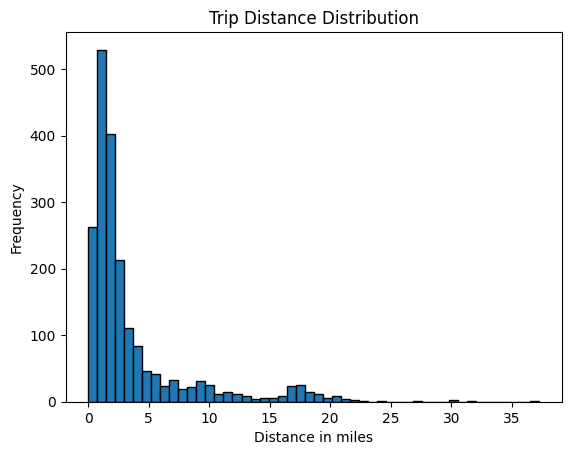

In [17]:
# distribution of trip distance

import matplotlib.pyplot as plt

trip_dist = tripdatav2.select("trip_distance").sample(False, 0.0001).toPandas() # a 0.01% representation was used to also visualize outliers
plt.hist(trip_dist["trip_distance"], bins=50, edgecolor='black')
plt.title("Trip Distance Distribution")
plt.xlabel("Distance in miles")
plt.ylabel("Frequency")
plt.show()

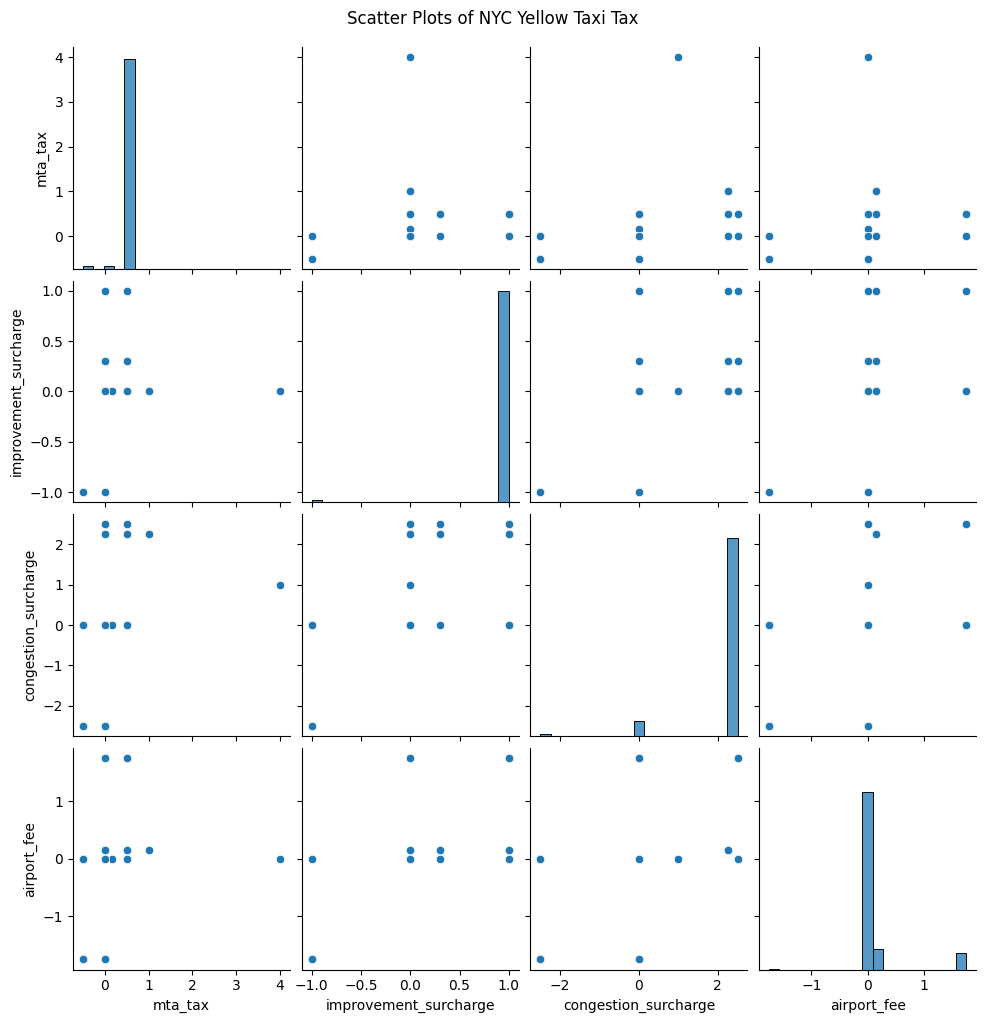

In [18]:
# Create a scatter plot for the tax revenues

import seaborn as sns

yt_tax = tripdatav2.select("mta_tax", "improvement_surcharge", "congestion_surcharge", "airport_fee") \
              .dropna() \
              .sample(False, 0.01) \
              .toPandas()

sns.pairplot(yt_tax)

plt.suptitle("Scatter Plots of NYC Yellow Taxi Tax", y=1.02)
plt.show()

In [19]:
# to review the trip duration column and its distribution

from pyspark.sql.functions import unix_timestamp, col

# Calculate duration in minutes
tripdatav3 = tripdatav2.withColumn("trip_duration",(unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 60)
# review the new column
tripdatav3.select("trip_duration").describe().show()

+-------+------------------+
|summary|     trip_duration|
+-------+------------------+
|  count|          20332093|
|   mean| 16.88492421890193|
| stddev| 34.56621359415994|
|    min|-52.06666666666667|
|    max| 9767.516666666666|
+-------+------------------+



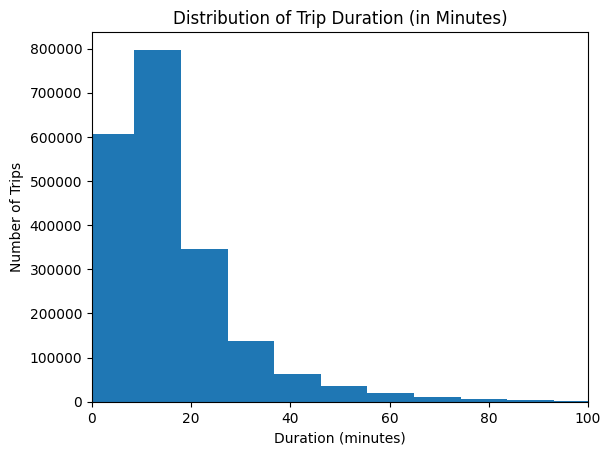

In [20]:
# visualize the trip duration column

# Sample for plotting
trip_durations = tripdatav3.select("trip_duration").sample(False, 0.1).toPandas()

# Plot histogram
plt.hist(trip_durations["trip_duration"], bins=500)
plt.title("Distribution of Trip Duration (in Minutes)")
plt.xlabel("Duration (minutes)")
plt.ylabel("Number of Trips")
plt.xlim(0, 100)
plt.show()

In [21]:
# match and update the dataset with the taxi_zone dataset

# identify each matching columns across both taxi_zone and yellow_taxi dataset above
PULocationID = tripdatav2['PULocationID']
DOLocationID = tripdatav2['DOLocationID']
LocationID = taxi_zones['LocationID']
Borough = taxi_zones['Borough']
Zone = taxi_zones['Zone']
service_zone = taxi_zones['service_zone']

In [22]:
# match taxi zone columns to PU(pickup) column and rename the new taxi_zones columns
tripdatav2_1 = tripdatav2.join(taxi_zones, tripdatav2['PULocationID']== taxi_zones['LocationID'], how='left').withColumnRenamed('Borough', 'PUBorough').withColumnRenamed('Zone', 'PUZone').withColumnRenamed('service_zone', 'PUService_zone')
# take out Location ID from taxi_zones after matching, as is no more needed
tripdatav2_1 = tripdatav2_1.drop('LocationID')

In [23]:
# match taxi zone columns to DO(dropoff) column with the updated DF above and also rename the new taxi_zones columns
tripdatav2_2 = tripdatav2_1.join(taxi_zones, tripdatav2['DOLocationID']== taxi_zones['LocationID'], how='left').withColumnRenamed('Borough', 'DOBorough').withColumnRenamed('Zone', 'DOZone').withColumnRenamed('service_zone', 'DOService_zone')
# also take out Location ID from taxi_zones after matching, as is no more needed
tripdatav2_2 = tripdatav2_2.drop('LocationID')

In [24]:
# now I want to merge the 2 DFs, rearrange the columns closer to the PU & DO codes
columns = tripdatav2_2.columns

col_num = [0, 1, 2, 3, 4, 5, 17, 18, 19, 6, 20, 21, 22, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
rearr_columns = [columns[i] for i in col_num]

tripdatav4 = tripdatav2_2.select(rearr_columns)

In [25]:
# the updated dataframe, and we will transform the dataset by adjusting the outliers on a case by case problem statements
tripdatav4.show(5)

+--------+--------------------+---------------------+---------------+-------------+------------+---------+--------------------+--------------+------------+---------+--------------------+--------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|PUBorough|              PUZone|PUService_zone|DOLocationID|DOBorough|              DOZone|DOService_zone|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+------------+---------+--------------------+--------------+------------+---------+--------------------+--------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|

In [26]:
"""
Data analysis Objective 1 - To analyze the top-10 pick-up locations(PUZone column) with the highest total fare amount(total_amount column)
------------------------------------------------------------------------------------------------------------------------------------------
"""

'\nData analysis Objective 1 - To analyze the top-10 pick-up locations(PUZone column) with the highest total fare amount(total_amount column)\n------------------------------------------------------------------------------------------------------------------------------------------\n'

In [27]:
# to show if any outliers for total_amount is a -ve value
neg_tot_amt = tripdatav4.filter(col("total_amount") < 5).count()
print(f"Number of trips with total_amount < $5: {neg_tot_amt}")

Number of trips with total_amount < $5: 361104


In [28]:
# to further show any outliers for total_amount that is too high, a benchmark of $200 was used
high_tot_amt = tripdatav4.filter(col("total_amount") > 200).count()
print(f"Number of trips with total_amount > $200: {high_tot_amt}")

Number of trips with total_amount > $200: 13631


In [29]:
# only keep total_amount > $5 and <=$200
amt_tripdatav4 = tripdatav4.filter(
    (col("total_amount") > 5) & (col("total_amount") <= 200))

In [30]:
# We can now proceed to get top-10 PU zones with the highest/lowest total_amount

from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, col

PUtrip_hrank = Window.partitionBy("PUZone").orderBy(col("total_amount").desc())
PUzone_h_rank = (amt_tripdatav4.withColumn("rank", row_number().over(PUtrip_hrank)).filter(col("rank") == 1).select("PUZone", "total_amount").withColumnRenamed("PUZone", "HighPUZone").withColumnRenamed("total_amount", "PUHighAmount"))

PUtrip_lrank  = Window.partitionBy("PUZone").orderBy(col("total_amount").asc())
PUzone_l_rank = (amt_tripdatav4.withColumn("rank", row_number().over(PUtrip_lrank)).filter(col("rank") == 1).select("PUZone", "total_amount").withColumnRenamed("PUZone", "LowPUZone").withColumnRenamed("total_amount", "PULowAmount"))


high_rank = Window.orderBy(col("PUHighAmount").desc())
low_rank = Window.orderBy(col("PULowAmount").asc())

top_h = (PUzone_h_rank.withColumn("row_num", row_number().over(high_rank)).filter(col("row_num") <= 10))

top_l = (PUzone_l_rank.withColumn("row_num", row_number().over(low_rank)).filter(col("row_num") <= 10))

top_10 = (top_h.join(top_l, on="row_num").select("HighPUZone", "PUHighAmount", "LowPUZone", "PULowAmount"))

# Show the result
top_10.show()

+--------------------+------------+--------------------+-----------+
|          HighPUZone|PUHighAmount|           LowPUZone|PULowAmount|
+--------------------+------------+--------------------+-----------+
|      Newark Airport|       200.0|        Clinton Hill|       5.01|
|Upper East Side S...|       200.0| Crown Heights North|       5.01|
|Upper East Side N...|       200.0|          Ocean Hill|       5.01|
|     Jamaica Estates|       200.0|         Old Astoria|       5.01|
|   LaGuardia Airport|       200.0|Stuy Town/Peter C...|       5.01|
|       Richmond Hill|       200.0|TriBeCa/Civic Center|       5.01|
|Washington Height...|       200.0|Upper West Side N...|       5.01|
| Lincoln Square East|       200.0|     Lenox Hill East|       5.01|
|       Midtown South|       200.0| UN/Turtle Bay South|       5.01|
|                 N/A|       200.0|            Union Sq|       5.01|
+--------------------+------------+--------------------+-----------+



In [31]:
"""
Data analysis Objective 2 - To analyze the top-10 Drop-off locations(DOZone column) with the highest total fare amount(total_amount column)
-------------------------------------------------------------------------------------------------------------------------------------------
"""

'\nData analysis Objective 2 - To analyze the top-10 Drop-off locations(DOZone column) with the highest total fare amount(total_amount column)\n-------------------------------------------------------------------------------------------------------------------------------------------\n'

In [32]:
# We can now proceed to get top-10 Drop Off zones with the highest/lowest total_amount

from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, col

DOtrip_hrank = Window.partitionBy("DOZone").orderBy(col("total_amount").desc())
DOzone_h_rank = (amt_tripdatav4.withColumn("rank", row_number().over(DOtrip_hrank)).filter(col("rank") == 1).select("DOZone", "total_amount").withColumnRenamed("DOZone", "HighDOZone").withColumnRenamed("total_amount", "DOHighAmount"))

DOtrip_lrank  = Window.partitionBy("DOZone").orderBy(col("total_amount").asc())
DOzone_l_rank = (amt_tripdatav4.withColumn("rank", row_number().over(PUtrip_lrank)).filter(col("rank") == 1).select("DOZone", "total_amount").withColumnRenamed("DOZone", "LowDOZone").withColumnRenamed("total_amount", "DOLowAmount"))


D_high_rank = Window.orderBy(col("DOHighAmount").desc())
D_low_rank = Window.orderBy(col("DOLowAmount").asc())

D_top_h = (DOzone_h_rank.withColumn("row_num", row_number().over(D_high_rank)).filter(col("row_num") <= 10))

D_top_l = (DOzone_l_rank.withColumn("row_num", row_number().over(D_low_rank)).filter(col("row_num") <= 10))

D_top_10 = (D_top_h.join(D_top_l, on="row_num").select("HighDOZone", "DOHighAmount", "LowDOZone", "DOLowAmount"))

# Show the result
D_top_10.show()

+--------------------+------------+--------------------+-----------+
|          HighDOZone|DOHighAmount|           LowDOZone|DOLowAmount|
+--------------------+------------+--------------------+-----------+
|      Newark Airport|       200.0|      Midtown Center|       5.01|
|     Jamaica Estates|       200.0|              Corona|       5.01|
|       Richmond Hill|       200.0|            Kips Bay|       5.01|
|                 N/A|       200.0|Central Harlem North|       5.01|
|West Chelsea/Huds...|       200.0|  World Trade Center|       5.01|
|      Outside of NYC|       200.0|   East Harlem North|       5.01|
|        Clinton East|      199.88|Washington Height...|       5.01|
|             Gowanus|      199.87|             Seaport|       5.01|
|Upper West Side N...|      199.85|Upper East Side N...|       5.01|
|         JFK Airport|      199.84|Financial Distric...|       5.01|
+--------------------+------------+--------------------+-----------+



In [33]:
"""
Data analysis Objective 3 - To analyze and rank if there are more during early drivetime(7-9am), lunchtime(12-2pm) and late drivetime(4pm-6pm)
----------------------------------------------------------------------------------------------------------------------------------------------
"""

'\nData analysis Objective 3 - To analyze and rank if there are more during early drivetime(7-9am), lunchtime(12-2pm) and late drivetime(4pm-6pm)\n----------------------------------------------------------------------------------------------------------------------------------------------\n'

In [34]:
# we firstly invalidate and check for any trip where pickup happened before dropoff
invalid_trip = amt_tripdatav4.filter(col("tpep_pickup_datetime") > col("tpep_dropoff_datetime")).count()
print(f"Number of trips where pickup time was earlier than dropoff time: {invalid_trip} rides")

Number of trips where pickup time was earlier than dropoff time: 300 rides


In [35]:
# next, are duration of rides are that are too short or too long, basetime of 1mins=too short and 150mins=for too long
# Calculate duration in minutes using the updated DF
time_tripdata = amt_tripdatav4.withColumn("trip_duration",(unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 60)

invalid_short = time_tripdata.filter(col("trip_duration") < 1).count() # for too short ride duration
print(f"Number of trips where ride duration were too short: {invalid_short} rides")

invalid_long = time_tripdata.filter(col("trip_duration") > 150).count() # for too short ride duration
print(f"Number of trips where ride duration were too long: {invalid_long} rides")

Number of trips where ride duration were too short: 179081 rides
Number of trips where ride duration were too long: 13849 rides


In [36]:
# only trips that are between 1min and 150mins
validtime_tripdata = time_tripdata.filter((col("tpep_pickup_datetime") < col("tpep_dropoff_datetime")) &
 (col("trip_duration") >= 1) &
 (col("trip_duration") <= 150))

from pyspark.sql.functions import hour, col

# Get the pickup hour
pickup_hour = validtime_tripdata.withColumn("pickup_hour", hour(col("tpep_pickup_datetime")))

# Get the dropoff hour
dropoff_hour = validtime_tripdata.withColumn("dropoff_hour", hour(col("tpep_dropoff_datetime")))

# Filter the time ranges
early_drivetime = pickup_hour.filter((col("pickup_hour") >= 7) & (col("pickup_hour") < 9)).count() + dropoff_hour.filter((col("dropoff_hour") >= 7) & (col("dropoff_hour") < 9)).count()

noon_drivetime = pickup_hour.filter((col("pickup_hour") >= 12) & (col("pickup_hour") < 14)).count() + dropoff_hour.filter((col("dropoff_hour") >= 12) & (col("dropoff_hour") < 14)).count()

late_drivetime = pickup_hour.filter((col("pickup_hour") >= 16) & (col("pickup_hour") < 18)).count() + dropoff_hour.filter((col("dropoff_hour") >= 16) & (col("dropoff_hour") < 18)).count()

# Display results
print("Ride Counts by Time Range:")
print(f"7–9 AM:   {early_drivetime} rides")
print(f"12–2 PM:  {noon_drivetime} rides")
print(f"4–6 PM:   {late_drivetime} rides")


Ride Counts by Time Range:
7–9 AM:   2499582 rides
12–2 PM:  4239195 rides
4–6 PM:   5091983 rides


In [37]:
"""
Data analysis Objective 4 - To analyze and rank{focusing on only the top-5} pickup(PUzone) and dropoff(DOzone) with more rides per Borough
------------------------------------------------------------------------------------------------------------------------------------------
"""

'\nData analysis Objective 4 - To analyze and rank{focusing on only the top-5} pickup(PUzone) and dropoff(DOzone) with more rides per Borough\n------------------------------------------------------------------------------------------------------------------------------------------\n'

In [38]:
# we identify the unique Borough from the taxi_zone dataset
taxi_zones.select("Borough").distinct().show()

+-------------+
|      Borough|
+-------------+
|       Queens|
|          EWR|
|      Unknown|
|     Brooklyn|
|Staten Island|
|          N/A|
|    Manhattan|
|        Bronx|
+-------------+



In [39]:
# then identify the unknown and N/A Boroughs from PU/DO
invalid_p_Borough = time_tripdata.filter((col("PUBorough").isin("Unknown", "N/A"))).count()
print(f"Number of pickup rides that has unknown and N/A Borough entries: {invalid_p_Borough} rides")

invalid_d_Borough = time_tripdata.filter((col("DOBorough").isin("Unknown", "N/A"))).count()
print(f"Number of dropoff rides that has unknown and N/A Borough entries: {invalid_d_Borough} rides")

Number of pickup rides that has unknown and N/A Borough entries: 73134 rides
Number of dropoff rides that has unknown and N/A Borough entries: 165479 rides


In [40]:
# we proceed to use the dataset without "unknown" and "NA" entries for each PU(D0)Boroughs
Borough_tripdata = validtime_tripdata.filter((~col('PUBorough').isin("Unknown", "N/A")) & (~col('DOBorough').isin("Unknown", "N/A")))

In [41]:
from pyspark.sql.functions import count

# Get the same Borough represented for each analysis
PU_DO_b = Borough_tripdata.filter(col("PUBorough") == col("DOBorough"))

# Then proceed to get the top zones per PU(DO) Borough
def top_zones(df, borough_col, zone_col, alias_prefix):
    zone_counts = df.groupBy(borough_col, zone_col).agg(count("*").alias(f"{alias_prefix}_rides"))
    window_spec = Window.partitionBy(borough_col).orderBy(col(f"{alias_prefix}_rides").desc())
    return zone_counts.withColumn("rank", row_number().over(window_spec)).filter(col("rank") <= 5)

# for the pick up zones
top_pu = top_zones(PU_DO_b, "PUBorough", "PUZone", "PU").selectExpr("PUBorough", "PUZone", "PU_rides", "rank as pu_rank")

# for the drop off zones
top_do = top_zones(PU_DO_b, "DOBorough", "DOZone", "DO").selectExpr("DOBorough", "DOZone", "DO_rides", "rank as do_rank")

# Align final putput side by side
combined_z = top_pu.join(top_do,(top_pu.PUBorough == top_do.DOBorough) & (top_pu.pu_rank == top_do.do_rank),how="inner").select(
    top_pu.PUBorough,
    top_pu.PUZone,
    top_pu.PU_rides,
    top_do.DOBorough,
    top_do.DOZone,
    top_do.DO_rides
).filter(
    col("PUBorough").isin("Bronx", "Manhattan", "Brooklyn", "Queens", "Staten Island")
)


combined_z.orderBy("PUBorough", "pu_rank").show(25) # 5 zones x 5 Borough = 25

+-------------+--------------------+--------+-------------+--------------------+--------+
|    PUBorough|              PUZone|PU_rides|    DOBorough|              DOZone|DO_rides|
+-------------+--------------------+--------+-------------+--------------------+--------+
|        Bronx|Mott Haven/Port M...|    1913|        Bronx|Mott Haven/Port M...|    1240|
|        Bronx|       Melrose South|    1016|        Bronx|       Melrose South|     929|
|        Bronx|          Co-Op City|     965|        Bronx|East Concourse/Co...|     898|
|        Bronx|      West Concourse|     946|        Bronx|Van Nest/Morris Park|     876|
|        Bronx|Soundview/Castle ...|     877|        Bronx|          Co-Op City|     799|
|     Brooklyn| Crown Heights North|    6442|     Brooklyn| Crown Heights North|    6627|
|     Brooklyn|         Fort Greene|    5645|     Brooklyn|          Park Slope|    5868|
|     Brooklyn|         Boerum Hill|    5515|     Brooklyn|       East New York|    4832|
|     Broo

In [42]:
"""
Data analysis Objective 5 - To analyze and rank total taxes(Jan-June) generated monthly
---------------------------------------------------------------------------------------
"""

'\nData analysis Objective 5 - To analyze and rank total taxes(Jan-June) generated monthly\n---------------------------------------------------------------------------------------\n'

In [43]:
# there are 4 tax revenue columns in the dataset - mta_tax, improvement_surcharge, congestion_surcharge and airport_fee
# and each has fixed amount per ride
# mta_tax = $0.5, imp_sur = $1.0 are fixed and constant
# con_sur = $2.5 and airp_fee = $1.75 are subject to the ride destination i.e they can be correctly $0 and their exact fee, but any other amount is an outlier
# we detect outliers by any amount not exactly as the above

not_mta_tax = Borough_tripdata.filter(col("mta_tax") != 0.5)
not_imp_sur = Borough_tripdata.filter(col("improvement_surcharge") != 1.0)
not_con_sur = Borough_tripdata.filter((col("congestion_surcharge") != 0.0) & (col("congestion_surcharge") != 2.5))
not_airp_fee = Borough_tripdata.filter((col("airport_fee") != 0.0) & (col("airport_fee") != 1.75))

count_nmt = not_mta_tax.count()
count_nis = not_imp_sur.count()
count_ncs = not_con_sur.count()
count_naf = not_airp_fee.count()

print(f"The mta_tax outliers rides are {count_nmt} rides")
print(f"The improvement surcharge outliers rides are {count_nis} rides")
print(f"The congestion surcharge outliers rides are {count_ncs} rides")
print(f"The airport fee outliers rides are {count_naf} rides")

print(f"Total tax outlier rides are {count_nmt + count_nis + count_ncs + count_naf} rides")

The mta_tax outliers rides are 100686 rides
The improvement surcharge outliers rides are 74491 rides
The congestion surcharge outliers rides are 1874054 rides
The airport fee outliers rides are 1874063 rides
Total tax outlier rides are 3923294 rides


In [44]:
# change both congestion surcharge and airport fee with $0 each

from pyspark.sql.functions import when

tax_tripdata = Borough_tripdata.withColumn("congestion_surcharge",when((col("congestion_surcharge").isin(0.0, 2.5)), col("congestion_surcharge")).otherwise(0.0)).withColumn(
    "airport_fee",when((col("airport_fee").isin(0.0, 1.75)), col("airport_fee")).otherwise(0.0))

In [45]:
from pyspark.sql.functions import month, year, to_date

# then also check for outliers are outside the set months of Jan - June and Year is 2024
outlier_months = tax_tripdata.filter(
    ~((year("tpep_pickup_datetime") == 2024) & (month("tpep_pickup_datetime").isin(1, 2, 3, 4, 5, 6))))
count_om = outlier_months.count()
print(f"the total rides outside Jan-June of our dataset are {count_om} rides")

the total rides outside Jan-June of our dataset are 23 rides


In [46]:
# focus on rides within Jan-June of 2024
months_tripdata = tax_tripdata.filter(
    (year("tpep_pickup_datetime") == 2024) & (month("tpep_pickup_datetime").isin(1, 2, 3, 4, 5, 6)))

In [47]:
from pyspark.sql.functions import sum as Fsum, concat_ws
from pyspark.sql.functions import rank
from pyspark.sql.types import DecimalType

# arrange each ride by month
taxes_month = months_tripdata.withColumn("Month", concat_ws("-", year("tpep_pickup_datetime"), month("tpep_pickup_datetime")))

# sum taxes per month
total_taxes = taxes_month.groupBy("Month").agg(
    Fsum("mta_tax").alias("total_mta"),
    Fsum("improvement_surcharge").alias("total_improvement"),
    Fsum("congestion_surcharge").alias("total_congestion"),
    Fsum("airport_fee").alias("total_airport"))

# include the total_tax column above
total_taxes = total_taxes.withColumn("total_tax",col("total_mta") + col("total_improvement") + col("total_congestion") + col("total_airport"))


# then we rank each month total taxes
window_spec = Window.orderBy(col("total_tax").desc())
total_taxes = total_taxes.withColumn("rank_total_tax", rank().over(window_spec))

# round of total taxes to 2 decimal points
total_taxes = total_taxes.withColumn("total_tax", col("total_tax").cast(DecimalType(20, 2)))
total_taxes.orderBy("rank_total_tax").show(truncate=False)

+------+----------+------------------+----------------+-------------+-----------+--------------+
|Month |total_mta |total_improvement |total_congestion|total_airport|total_tax  |rank_total_tax|
+------+----------+------------------+----------------+-------------+-----------+--------------+
|2024-5|1780787.8 |3544556.900000006 |7444807.5       |484601.25    |13254753.45|1             |
|2024-3|1715014.09|3445759.3000000063|7109402.5       |439568.5     |12709744.39|2             |
|2024-6|1689240.08|3364423.100000006 |7006557.5       |454020.0     |12514240.68|3             |
|2024-4|1681907.5 |3380323.000000007 |6971220.0       |444437.0     |12477887.50|4             |
|2024-2|1446730.5 |2906084.7000000044|6393280.0       |354947.25    |11101042.45|5             |
|2024-1|1426206.0 |2864940.000000005 |6365657.5       |386741.25    |11043544.75|6             |
+------+----------+------------------+----------------+-------------+-----------+--------------+



In [ ]:
"""
HDFS Task 1 - Write the script that will read the data from HDFS
"""

# the script to access HDFS, with an assumption if there was a HDFS_path

from pyspark.sql import SparkSession

# HDFS path
hdfs_path = "hdfs://namenode_host:9000"

# Paths to the datasets
taxi_zone_path = f"{hdfs_path}/data/taxi/taxi_zone_lookup.csv"
tripdata1_path = f"{hdfs_path}/data/taxi/yellow_tripdata_2024-01.parquet"
tripdata2_path = f"{hdfs_path}/data/taxi/yellow_tripdata_2024-02.parquet"
tripdata3_path = f"{hdfs_path}/data/taxi/yellow_tripdata_2024-03.parquet"
tripdata4_path = f"{hdfs_path}/data/taxi/yellow_tripdata_2024-04.parquet"
tripdata5_path = f"{hdfs_path}/data/taxi/yellow_tripdata_2024-05.parquet"
tripdata6_path = f"{hdfs_path}/data/taxi/yellow_tripdata_2024-06.parquet"

"""
HDFS Task 2 - Save the clean and processed data
"""
# path to the cleaned data
tripdatav2_path = f"{hdfs_path}/data/taxi/tripdatav2"

# Save it
tripdatav2.write.mode("overwrite").format("csv").save("tripdatav2_path")